# Advanced Lane Finding Using OpenCV
**In this project, I used OpenCV to write a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car.**

## Pipeline architecture:
- **Compute Camera Calibration.**
- **Apply Distortion Correction**.
- **Apply a Perspective Transform.**
- **Create a Thresholded Binary Image.**
- **Define the Image Processing Pipeline.**
- **Detect Lane Lines.**
- **Determine the Curvature of the Lane and Vehicle Position.**
- **Visual display of the Lane Boundaries and Numerical Estimation of Lane Curvature and Vehicle Position.**
- **Process Project Videos.**

I'll explain each step in details below.

#### Environement:
-  Ubuntu 16.04
-  Anaconda 5.0.1
-  Python 3.6.2
-  OpenCV 3.1.0

In [1]:
# Importing Python libraries
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
def display(img1, img2, lbl1, lbl2, x, y, img3=[], lbl3=[], cmap=None, n = 2):
    """
    Diplay the input images side-by-side.
        Parameters:
            img1: Input image #1.
            img2: Input image #2.
            lbl1: Label for input image #1.
            lbl2: Label for input image #2.
            x, y: Figure size.
            cmap (Default = None): Used to display gray images.
    """
    plt.figure(figsize=(x, y))
    plt.subplot(1, n, 1)
    plt.imshow(img1, cmap = cmap)
    plt.xlabel(lbl1, fontsize=15)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, n, 2)
    plt.imshow(img2, cmap = cmap)
    plt.xlabel(lbl2, fontsize=15)
    plt.xticks([])
    plt.yticks([])
    if n == 3:
        plt.subplot(1, n, 3)
        plt.imshow(img3, cmap = cmap)
        plt.xlabel(lbl3, fontsize=15)
        plt.xticks([])
        plt.yticks([])
    plt.show()

---
## Step 1: Compute Camera Calibration

The OpenCV functions `cv2.findChessboardCorners()` and `cv2.drawChessboardCorners()` are used for image calibration. We have 20 images of a chessboard, located in `./camera_cal`, taken from different angles with the same camera, and we'll use them as input for camera calibration routine.

`cv2.findChessboardCorners()` attempts to determine whether the input image is a view of the chessboard pattern and locate the internal chessboard corners, and then `cv2.drawChessboardCorners()` draws individual chessboard corners detected.

Arrays of object points, corresponding to the location of internal corners of a chessboard, and image points, the pixel locations of the internal chessboard corners determined by `cv2.findChessboardCorners()`, are fed to `cv2.drawChessboardCorners()` which returns camera calibration and distortion coefficients.


These will then be used by the OpenCV `cv2.calibrateCamera()` to find the camera intrinsic and extrinsic parameters from several views of a calibration pattern. These parameters will be fed to `cv2.undistort` function to correct for distortion on any image produced by the same camera.

In [20]:
cal_images = glob.glob('camera_cal/*.jpg')
# test_images = glob.glob('test_images/*.jpg')
test_images = glob.glob('mclean_images/*.jpg')

nx, ny = 9, 6
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1, 2)

In [11]:
def calibrate_camera(cal_images, nx, ny):
    """
    Compute camera calibration and return the camera intrinsic and extrinsic parameters.
        Parameters:
            cal_images: A list of the chessboard calibration images.
            nx, ny: Chessboard dimensions.
    """
    objpoints = []  # 3D points
    imgpoints = []  # 2D points
    
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1, 2)

    for file in cal_images:
        img = cv2.imread(file)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    return mtx, dist

In [12]:
mtx, dist = calibrate_camera(cal_images, nx, ny)

---
## Step 2: Apply Distortion Correction

OpenCV provides `cv2.undistort` function, which transforms an image to compensate for radial and tangential lens distortion.

In [13]:
def undistort(img, mtx, dist):
    """
    Use the camera calibration parameters to correct the input image for distortion.
        Parameters:
            img: Input image.
            mtx: Output floating-point camera matrix.
            dist: Output vector of distortion coefficients.
    """
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

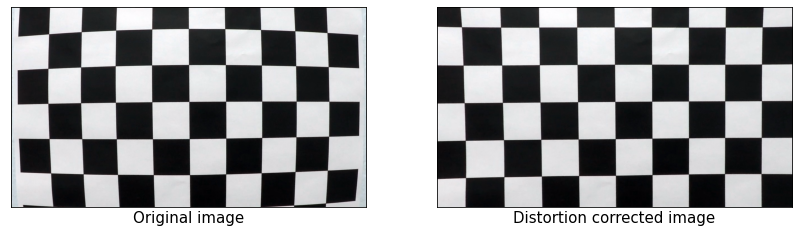

In [14]:
# Testing distortion correction on cal_images
img = cv2.imread(cal_images[0])
undist = undistort(img, mtx, dist)
display(img, undist, 'Original image', 'Distortion corrected image', 14, 7)

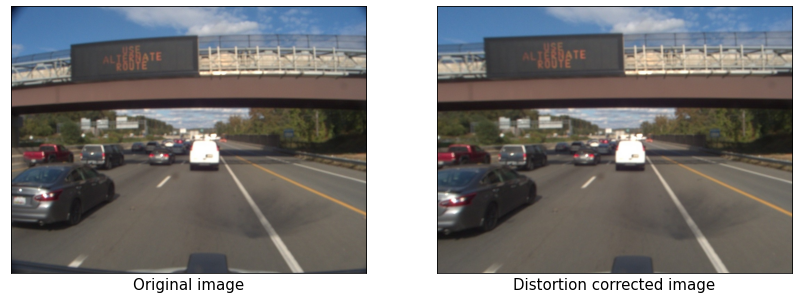

In [21]:
# Testing distortion correction on test_images
img = cv2.cvtColor(cv2.imread(test_images[0]), cv2.COLOR_BGR2RGB)
undist_img_ex = undistort(img, mtx, dist)
display(img, undist_img_ex, 'Original image', 'Distortion corrected image', 14, 7)

The effect of `undistort` is particularly noticeable, by the change in shape of the car hood at the bottom corners of the image.

---
## Step 3: Apply a Perspective Transform

A common task in autonomous driving is to convert the vehicle’s camera view of the scene into a top-down “bird’s-eye” view. We'll use OpenCV's `cv2.getPerspectiveTransform()` and `cv2.getPerspectiveTransform()` to do this task.

Image shape: (768, 1024, 3)


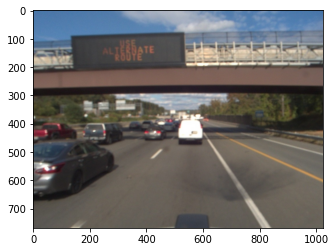

In [22]:
image_shape = undist_img_ex.shape
print("Image shape:", image_shape)
plt.imshow(undist_img_ex)
plt.show()

# test_images shape is (720, 1280, 3)
# mclean_images shape is (768, 1024, 3)

In [26]:
# Define the region of interest
# src = np.float32([[190, 700], [1110, 700], [720, 470], [570, 470]])
src = np.float32([[150, 700], [850, 700], [650, 400], [450, 400]])

# bottom_left = src[0][0]+100, src[0][1]
# bottom_right = src[1][0]-200, src[1][1]
# top_left = src[3][0]-250, 1
# top_right = src[2][0]+200, 1
bottom_left = src[0][0]+100, src[0][1]
bottom_right = src[1][0]-200, src[1][1]
top_left = src[3][0]-250, 1
top_right = src[2][0]+200, 1
dst = np.float32([bottom_left, bottom_right, top_right, top_left])

In [24]:
def perspective_transform(img, src, dst):
    """
     Convert the vehicle’s camera view of the scene into a top-down “bird’s-eye” view.
        Parameters:
            img: Input image.
            src: Source points.
            dst: Destination points.
    """
    image_shape = img.shape
    img_size = (image_shape[1], image_shape[0])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)
    # Return the resulting image and matrix
    return warped, M, Minv

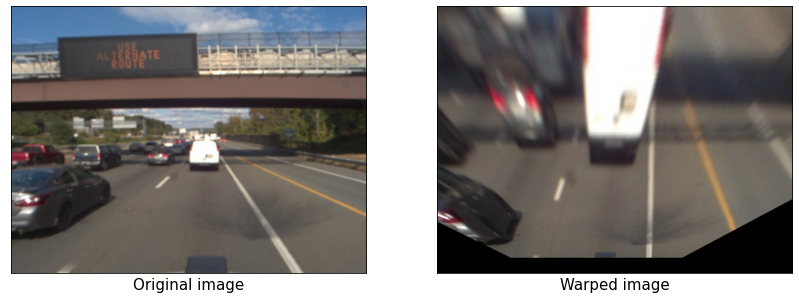

In [28]:
# Applying perspective transform to several test_images
display(undistort(cv2.cvtColor(cv2.imread(test_images[0]), cv2.COLOR_BGR2RGB), mtx, dist),
        perspective_transform(undistort(cv2.cvtColor(cv2.imread(test_images[0]), cv2.COLOR_BGR2RGB),
                                        mtx, dist), src, dst)[0],
        'Original image', 'Warped image', 14, 7)
# display(undistort(cv2.cvtColor(cv2.imread(test_images[1]), cv2.COLOR_BGR2RGB), mtx, dist),
#         perspective_transform(undistort(cv2.cvtColor(cv2.imread(test_images[1]), cv2.COLOR_BGR2RGB),
#                                         mtx, dist), src, dst)[0],
#         'Original image', 'Warped image', 14, 7)
# display(undistort(cv2.cvtColor(cv2.imread(test_images[7]), cv2.COLOR_BGR2RGB), mtx, dist),
#         perspective_transform(undistort(cv2.cvtColor(cv2.imread(test_images[7]), cv2.COLOR_BGR2RGB),
#                                         mtx, dist), src, dst)[0],
#         'Original image', 'Warped image', 14, 7)
# display(undistort(cv2.cvtColor(cv2.imread(test_images[6]), cv2.COLOR_BGR2RGB), mtx, dist),
#         perspective_transform(undistort(cv2.cvtColor(cv2.imread(test_images[6]), cv2.COLOR_BGR2RGB),
#                                         mtx, dist), src, dst)[0],
#         'Original image', 'Warped image', 14, 7)

In [29]:
undist_example_warped = perspective_transform(undist_img_ex, src, dst)[0]

---
## Step 4: Create a Thresholded Binary Image

Now, we will use color transform and Sobel differentiation to detect the lane lines in the image.

### Exploring different color spaces

#### RGB color space:

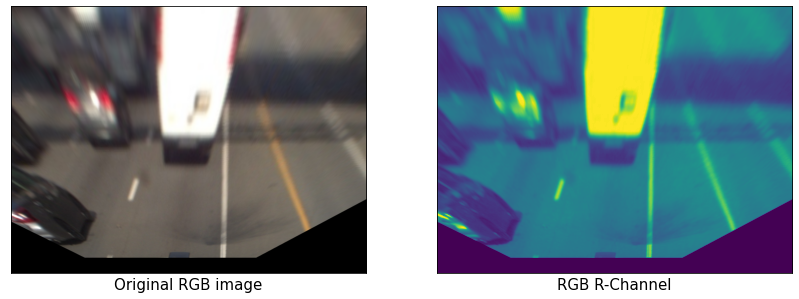

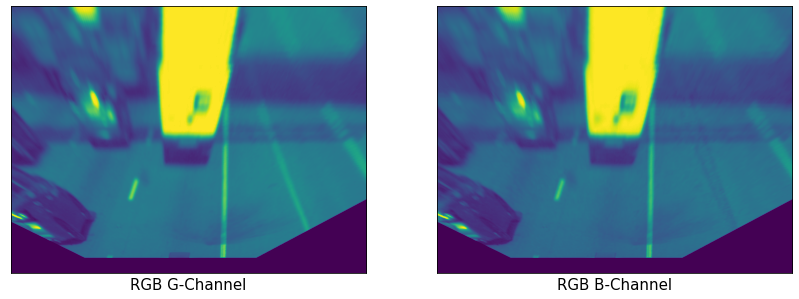

In [30]:
undist_example_RGB = undist_example_warped
undist_example_R = undist_example_RGB[:,:,0]
undist_example_G = undist_example_RGB[:,:,1]
undist_example_B = undist_example_RGB[:,:,2]

display(undist_example_RGB, undist_example_R, 'Original RGB image', 'RGB R-Channel', 14, 7)
display(undist_example_G, undist_example_B, 'RGB G-Channel', 'RGB B-Channel', 14, 7)

#### HSV color space:
This type of color model closely emulates models of human color perception. While in other color models, such as RGB, an image is treated as an additive result of three base colors, the three channels of HSV represent hue (H gives a measure of the spectral composition of a color), saturation (S gives the proportion of pure light of the dominant wavelength, which indicates how far a color is from a gray of equal brightness), and value (V gives the brightness relative to
the brightness of a similarly illuminated white color) corresponding to the intuitive appeal of tint, shade, and tone.

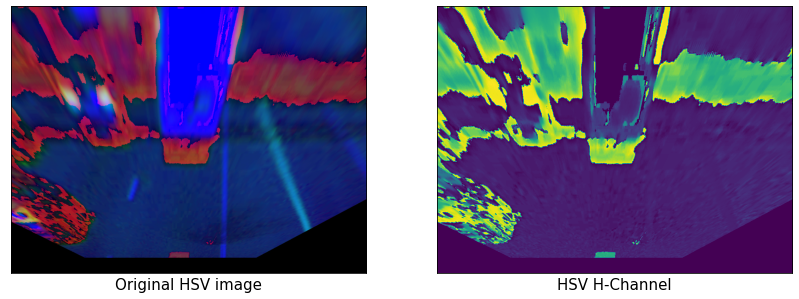

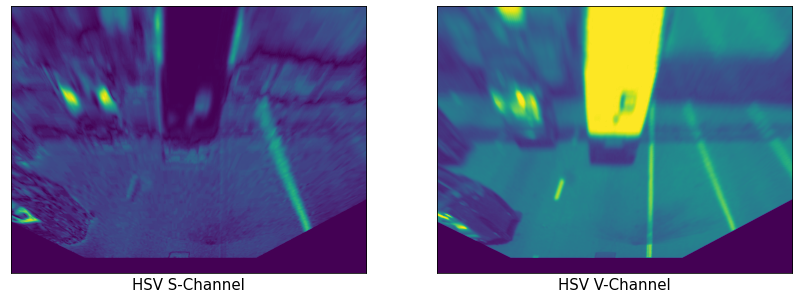

In [31]:
undist_example_HSV = cv2.cvtColor(undist_example_RGB, cv2.COLOR_RGB2HSV)
undist_example_HSV_H = undist_example_HSV[:,:,0]
undist_example_HSV_S = undist_example_HSV[:,:,1]
undist_example_HSV_V = undist_example_HSV[:,:,2]

display(undist_example_HSV, undist_example_HSV_H, 'Original HSV image', 'HSV H-Channel', 14, 7)
display(undist_example_HSV_S, undist_example_HSV_V, 'HSV S-Channel', 'HSV V-Channel', 14, 7)

#### LAB color space:
The Lab color space describes mathematically all perceivable colors in the three dimensions L for lightness and a and b for the color opponents green–red and blue–yellow.

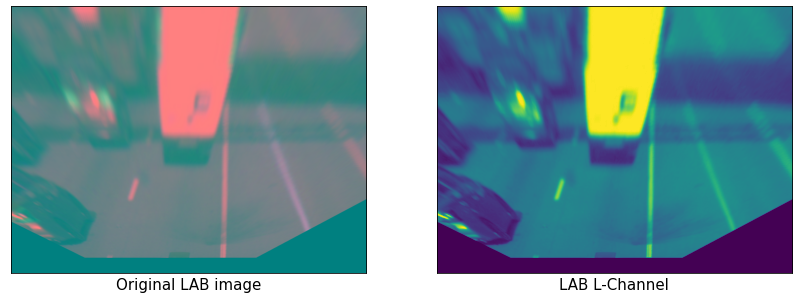

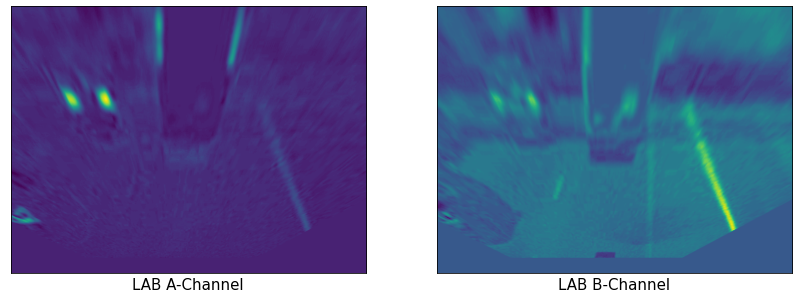

In [32]:
undist_example_LAB = cv2.cvtColor(undist_example_RGB, cv2.COLOR_RGB2Lab)
undist_example_LAB_L = undist_example_LAB[:,:,0]
undist_example_LAB_A = undist_example_LAB[:,:,1]
undist_example_LAB_B = undist_example_LAB[:,:,2]

display(undist_example_LAB, undist_example_LAB_L, 'Original LAB image', 'LAB L-Channel', 14, 7)
display(undist_example_LAB_A, undist_example_LAB_B, 'LAB A-Channel', 'LAB B-Channel', 14, 7)

#### HLS color space:
This model was developed to specify the values of hue, lightness, and saturation of a color in each channel. The difference with respect to the HSV color model is that the lightness of a pure color defined by HLS is equal to the lightness of a medium gray, while the brightness of a pure color defined by HSV is equal to the brightness of white.

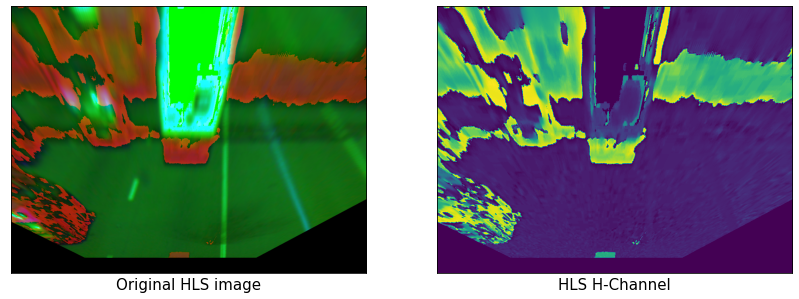

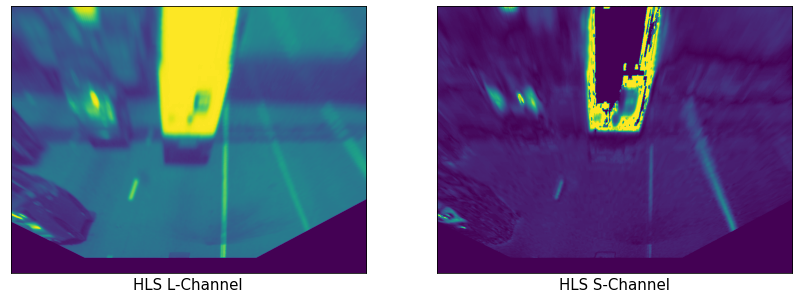

In [33]:
undist_example_HLS = cv2.cvtColor(undist_example_RGB, cv2.COLOR_RGB2HLS)
undist_example_HLS_H = undist_example_HLS[:,:,0]
undist_example_HLS_L = undist_example_HLS[:,:,1]
undist_example_HLS_S = undist_example_HLS[:,:,2]

display(undist_example_HLS, undist_example_HLS_H, 'Original HLS image', 'HLS H-Channel', 14, 7)
display(undist_example_HLS_L, undist_example_HLS_S, 'HLS L-Channel', 'HLS S-Channel', 14, 7)

### Color Space Thresholding

As you may observe, the white lane lines are clearly highlighted in the L-channel of the of the HLS color space, and the yellow line are clear in the L-channel of the LAP color space as well. We'll apply HLS L-threshold and LAB B-threshold to the image to highlight the lane lines.

In [34]:
def hls_l_thresh(img, thresh=(220, 255)):
    """
     Threshold the input image to the L-channel of the HLS color space.
        Parameters:
            img: HLS image.
            thresh: Minimum and Maximum color intensity.
    """
    img = img[:,:,1]
    img = img*(255/np.max(img))
    binary_output = np.zeros_like(img)
    binary_output[(img > thresh[0]) & (img <= thresh[1])] = 1
    return binary_output

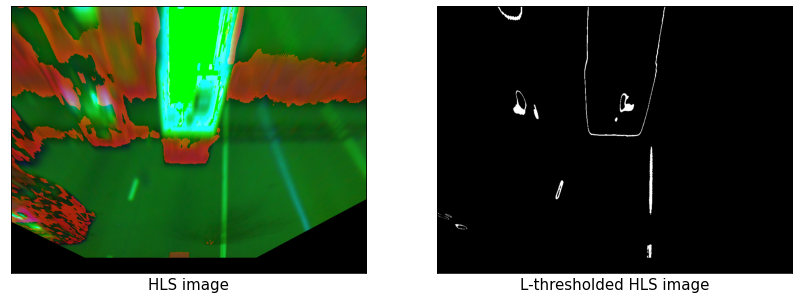

In [38]:
thresh_HLS = hls_l_thresh(undist_example_HLS, thresh=(175, 200))
display(undist_example_HLS, thresh_HLS, 'HLS image', 'L-thresholded HLS image', 14, 7, cmap = 'gray')

In [44]:
def lab_l_thresh(img, thresh=(190, 255)):
    """
     Threshold the input image to the L-channel of the LAB color space.
        Parameters:
            img: LAB image.
            thresh: Minimum and Maximum color intensity.
    """
    img = img[:,:,0]
    if np.max(img) > 175:
        img = img*(255/np.max(img))
    binary_output = np.zeros_like(img)
    binary_output[(img > thresh[0]) & (img <= thresh[1])] = 1
    return binary_output

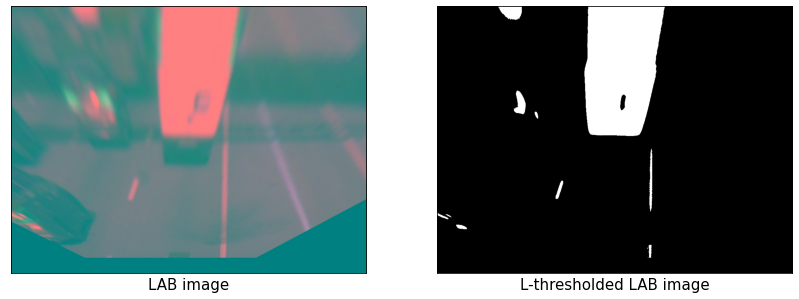

In [45]:
thresh_LAB = lab_l_thresh(undist_example_LAB)
display(undist_example_LAB, thresh_LAB, 'LAB image', 'L-thresholded LAB image', 14, 7, cmap = 'gray')

In [46]:
def threshold_color_space(img):
    """
     Threshold the input image to the L-channel of the HLS color space and the L-channel of the LAB color space.
        Parameters:
            img: Input image.
    """
    img_HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    img_LAB = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    img_thresh_HLS = hls_l_thresh(img_HLS)
    img_thresh_LAB = lab_l_thresh(img_LAB)
    combined_img = np.zeros_like(img_thresh_HLS)
    combined_img[((img_thresh_HLS == 1) | (img_thresh_LAB == 1))] = 1
    return combined_img

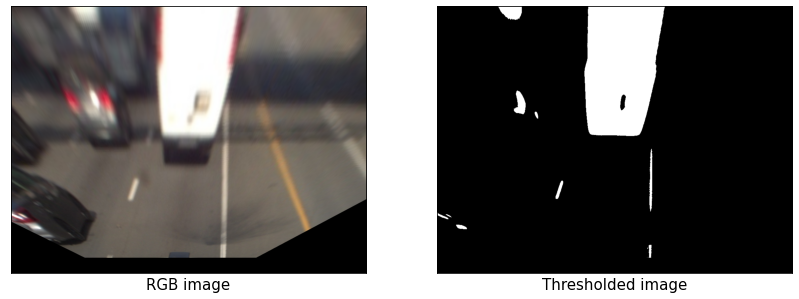

In [47]:
threshold_color_img = threshold_color_space(undist_example_warped)
display(undist_example_warped, threshold_color_img, 'RGB image', 'Thresholded image', 14, 7, cmap = 'gray')

### Sobel Differentiation

Now, we'll explore different Sobel differentiation techniques, and try to come up with a combination that produces a better output than color space thresholding.

In [52]:
def abs_sobel(img, orient='x', sobel_kernel=3, thresh=(25, 255)):
    """
    Apply absolute Sobel diffrentiation to the input image.
        Parameters:
            img: Input image.
            orient (Default = x): Gradients direction.
            sobel_kernel (Default = 3): Size of the extended Sobel kernel.
            thresh (Default = (25, 255)): Minimum and Maximum gradient strength.
    """
    if orient == 'y':
        dx = 1
        dy = 0
    else:  # default is orient='x'
        dx = 0
        dy = 1
    sobel = cv2.Sobel(img, cv2.CV_64F, dx, dy, ksize= sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sxbinary

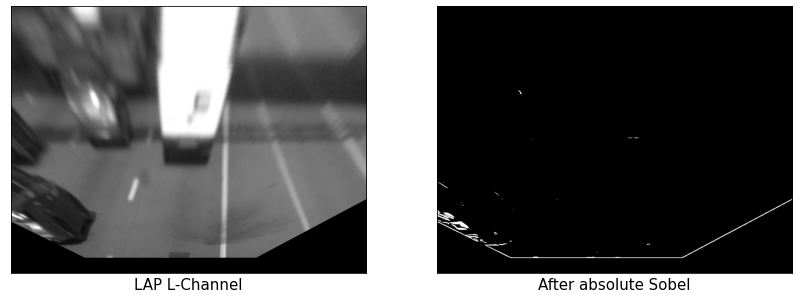

In [54]:
abs_sobel_example_LAB_L = abs_sobel(undist_example_LAB_L)
display(undist_example_LAB_L, abs_sobel_example_LAB_L, 'LAP L-Channel', 'After absolute Sobel', 14, 7, cmap='gray')

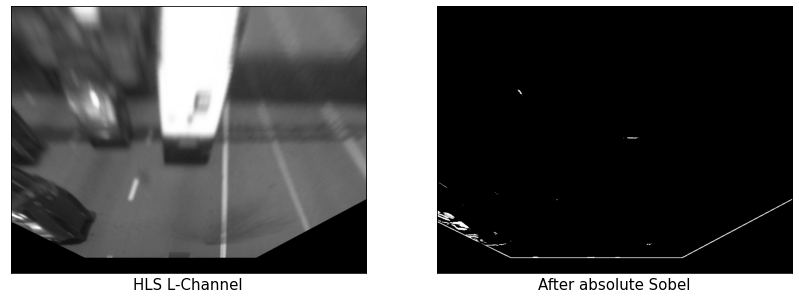

In [55]:
abs_sobel_example_HLS_L = abs_sobel(undist_example_HLS_L)
display(undist_example_HLS_L, abs_sobel_example_HLS_L, 'HLS L-Channel', 'After absolute Sobel', 14, 7, cmap='gray')

In [56]:
def mag_sobel(img, sobel_kernel=15, thresh=(25, 255)):
    """
    Apply magnitude Sobel diffrentiation to the input image.
        Parameters:
            img: Input image.
            sobel_kernel (Default = 15): Size of the extended Sobel kernel.
            thresh (Default = (25, 255)): Minimum and Maximum gradient strength.
    """
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    mag_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sxbinary

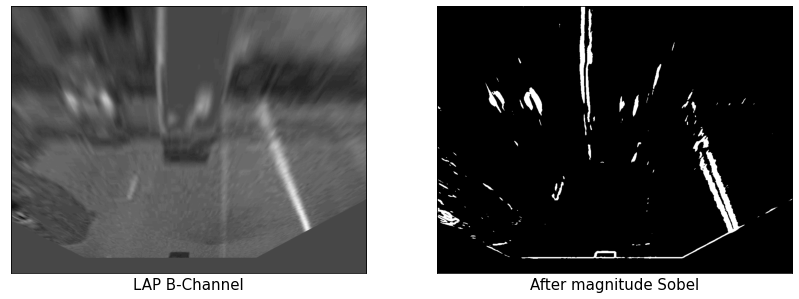

In [57]:
mag_sobel_example_LAB_B = mag_sobel(undist_example_LAB_B)
display(undist_example_LAB_B, mag_sobel_example_LAB_B, 'LAP B-Channel', 'After magnitude Sobel', 14, 7, cmap='gray')

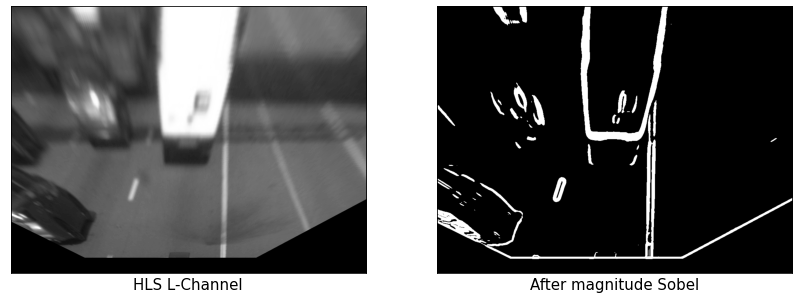

In [58]:
mag_sobel_example_HLS_L = mag_sobel(undist_example_HLS_L)
display(undist_example_HLS_L, mag_sobel_example_HLS_L, 'HLS L-Channel', 'After magnitude Sobel', 14, 7, cmap='gray')

In [59]:
def dir_sobel(img, sobel_kernel=25, thresh=(0, 0.09)):    
    """
    Apply direction Sobel diffrentiation to the input image.
        Parameters:
            img: Input image.
            sobel_kernel (Default = 25): Size of the extended Sobel kernel.
            thresh (Default = (0, 0.09)): Minimum and Maximum gradient strength.
    """
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    binary_output =  np.zeros_like(grad_dir)
    binary_output[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    return binary_output

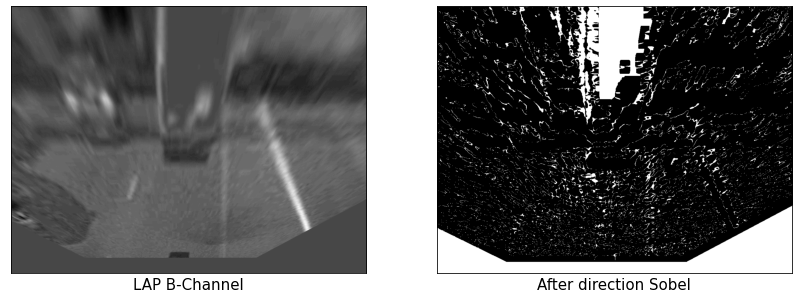

In [60]:
dir_sobel_example_LAB_B = dir_sobel(undist_example_LAB_B)
display(undist_example_LAB_B, dir_sobel_example_LAB_B, 'LAP B-Channel', 'After direction Sobel', 14, 7, cmap='gray')

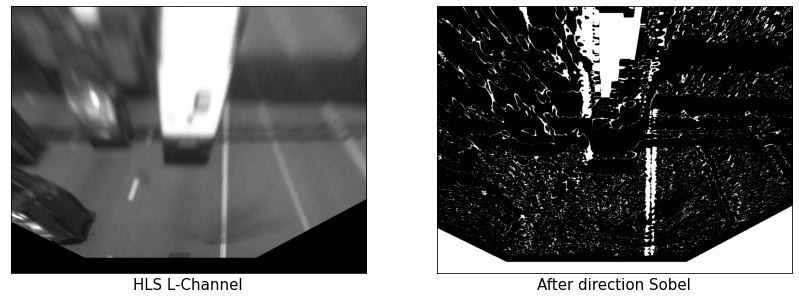

In [61]:
dir_sobel_example_HLS_L = dir_sobel(undist_example_HLS_L)
display(undist_example_HLS_L, dir_sobel_example_HLS_L, 'HLS L-Channel', 'After direction Sobel', 14, 7, cmap='gray')

In [62]:
def combined_sobel(img, mag_kernel_size, mag_thresh):
    """
    Apply both absolute and magnitude Sobel diffrentiation to the input image.
        Parameters:
            img: Input image.
            mag_kernel_size: Size of the extended Sobel kernel.
            mag_thresh: Minimum and Maximum gradient strength.
    """
    img_abs = abs_sobel(img)
    img_mag = mag_sobel(img, mag_kernel_size, mag_thresh)
    combined_img = np.zeros_like(img_mag)
    combined_img[((img_abs == 1) & (img_mag == 1))] = 1
    return combined_img

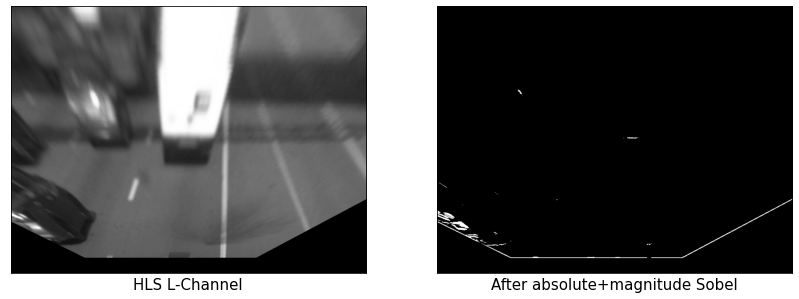

In [63]:
combined_HLS_L = combined_sobel(undist_example_HLS_L, 15, (25, 225))
display(undist_example_HLS_L, combined_HLS_L, 'HLS L-Channel', 'After absolute+magnitude Sobel', 14, 7, cmap='gray')

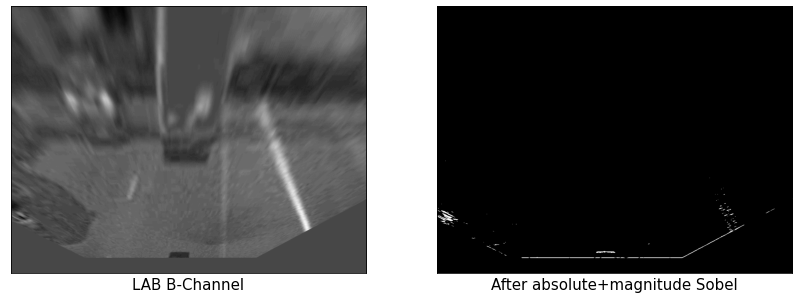

In [64]:
combined_LAB_B = combined_sobel(undist_example_LAB_B, 15, (25, 225))
display(undist_example_LAB_B, combined_LAB_B, 'LAB B-Channel', 'After absolute+magnitude Sobel', 14, 7, cmap='gray')

Now, we'll combine the absolute+magnitude Sobel outputs of both HLS and LAB.

In [65]:
def combined_sobel_colors(img, mag_kernel_size, mag_thresh):
    """
    Combine Sobel diffrentiation results from applying to diffrenet color spaces.
        Parameters:
            img: Input image.
            mag_kernel_size: Size of the extended Sobel kernel.
            mag_thresh: Minimum and Maximum gradient strength.
    """
    img_HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    img_LAB = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    combined_HLS_L = combined_sobel(img_HLS[:,:,1], mag_kernel_size, mag_thresh)
    combined_LAB_B = combined_sobel(img_LAB[:,:,2], mag_kernel_size, mag_thresh)
    combined_sobel_colors_img = np.zeros_like(combined_HLS_L)
    combined_sobel_colors_img[((combined_HLS_L == 1) | (combined_LAB_B == 1))] = 1
    return combined_sobel_colors_img

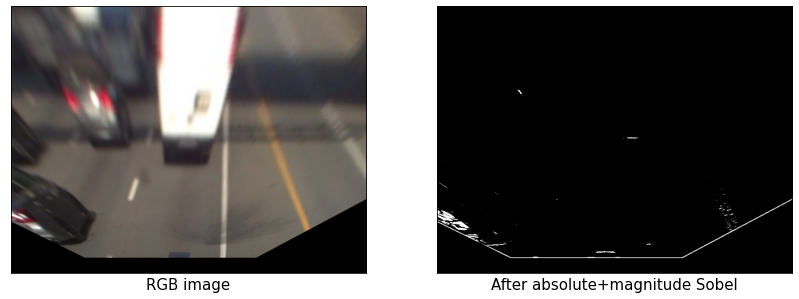

In [66]:
combined_sobel_colors_img = combined_sobel_colors(undist_example_RGB, 15, (25, 225))
display(undist_example_RGB, combined_sobel_colors_img, 'RGB image', 'After absolute+magnitude Sobel', 14, 7, cmap='gray')

### Comparison between Color Thresholding and Sobel Diffrentiation

We'll apply both color thresholding and Sobel diffrentiation to all the test images to explore which of these two techniques will be better to do the task.

In [67]:
color_threshold = []
sobel_diff = []
test_images_warped = []
for file in test_images:
    image = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
    image = undistort(image, mtx, dist)
    image = perspective_transform(image, src, dst)[0]
    test_images_warped.append(image)
    color_threshold.append(threshold_color_space(image))
    sobel_diff.append(combined_sobel_colors(image, 15, (25, 225)))

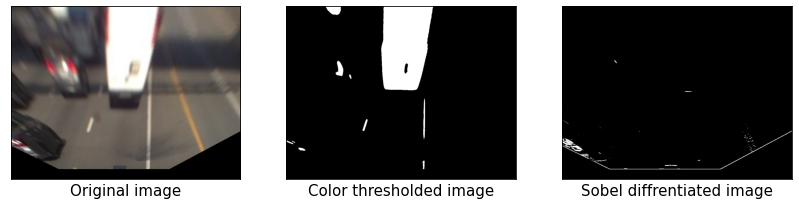

In [68]:
for original, color, sobel in zip(test_images_warped, color_threshold, sobel_diff):
    display(original,
            color,
            'Original image',
            'Color thresholded image',
            14,
            7,
            sobel,
            'Sobel diffrentiated image',
            cmap='gray',
            n = 3)

As you can see, although Sobel diffrentiation was able to capture the lane lines correctly, it captured some noise around it. On the other hand, color thresholding was able to produce clean output highlighting the lane lines.

---
## Step 5: Define the Image Processing Pipeline

Now, we'll define the complete image processing function to read the raw image and apply the following steps:
1. Distortion Correction.
2. Perspective Transform.
3. Color Thresholding.

In [69]:
def image_process(img):
    """
    Apply undistortion, perspective transform, and color space thresholding to the input image.
        Parameters:
            img: Input image.
    """
    # Undistort
    img = undistort(img, mtx, dist)
    
    # Perspective Transform
    img, M, Minv = perspective_transform(img, src, dst)

    # Create a thresholded binary image
    img = threshold_color_space(img)
    
    return img, Minv

In [70]:
test_images_imgs = []
test_images_processed = []
for file in test_images:
    image = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
    test_images_imgs.append(image)
    image, Minv = image_process(image)
    test_images_processed.append(image)

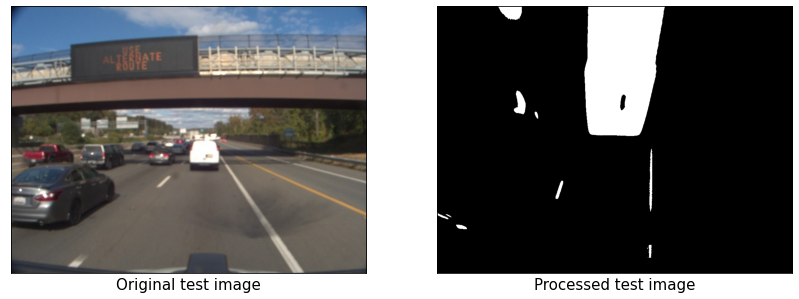

In [71]:
for original, processed in zip(test_images_imgs, test_images_processed):
    display(original,
            processed,
            'Original test image',
            'Processed test image',
            14,
            7,
            cmap='gray')

---
## Step 6: Detect the Lane Lines

After applying calibration, thresholding, and a perspective transform to a road image, we should have a binary image where the lane lines stand out clearly. However, we still need to decide explicitly which pixels are part of the lines and which belong to the left line and which belong to the right line.

### Sliding Window Search

We'll compute a histogram of the bottom half of the image and find the base of the left and right lane lines. Originally these locations were identified from the local maxima of the left and right halves of the histogram, but in the final implementation we used quarters of the histogram just left and right of the midpoint. This helped to reject lines from adjacent lanes. The function identifies 50 windows from which to identify lane pixels, each one centered on the midpoint of the pixels from the window below. This effectively "follows" the lane lines up to the top of the binary image, and speeds processing by only searching for activated pixels over a small portion of the image.

In [72]:
def sliding_window(img):
    """
    Fit a polynomial to the input binary image.
        Parameters:
            img: Input image.
    """
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    quarter_point = np.int(midpoint//2)
    # Previously the left/right base was the max of the left/right half of the histogram
    # this changes it so that only a quarter of the histogram (directly to the left/right) is considered
    leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 50
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Rectangle data for visualization
    rectangle_data = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &
                          (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &
                           (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    visualization_data = (rectangle_data, histogram)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data

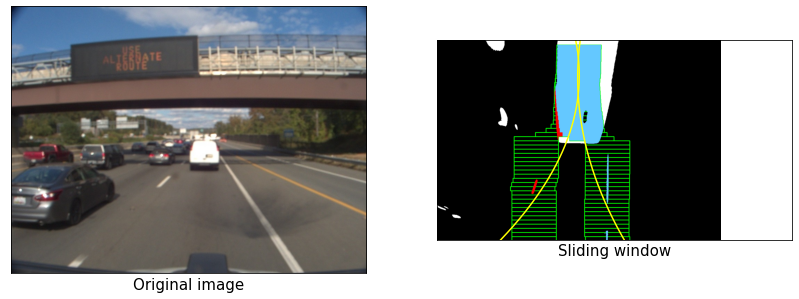

In [73]:
# Visualize the sliding windows over an example test image.

img = test_images_processed[0]
left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window(img)
h = img.shape[0]
left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
rectangles = visualization_data[0]
histogram = visualization_data[1]
# Create an output image to draw on and visualize the result
out_img = np.uint8(np.dstack((img, img, img))*255)
# Generate x and y values for plotting
ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
for rect in rectangles:
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
    cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 
# Identify the x and y positions of all nonzero pixels in the image
nonzero = img.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.imshow(original)
plt.xlabel('Original image', fontsize=15)
plt.xticks([])
plt.yticks([])
plt.subplot(1, 2, 2)
plt.imshow(out_img)
plt.xlabel('Sliding window', fontsize=15)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.xticks([])
plt.yticks([])
plt.show()

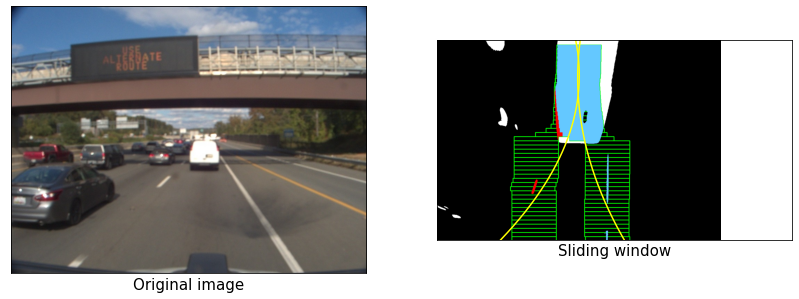

In [74]:
# Visualize the sliding windows over the test images.

for original, processed in zip(test_images_imgs, test_images_processed):
    img = processed
    left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window(img)
    h = img.shape[0]
    left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
    right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
    rectangles = visualization_data[0]
    histogram = visualization_data[1]
    # Create an output image to draw on and visualize the result
    out_img = np.uint8(np.dstack((img, img, img))*255)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    for rect in rectangles:
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
        cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.xlabel('Original image', fontsize=15)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 2, 2)
    plt.imshow(out_img)
    plt.xlabel('Sliding window', fontsize=15)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.xticks([])
    plt.yticks([])
    plt.show()

### Polyfit Using Fit from Previous Frame

The Polyfit Using Fit from Previous Frame is another way that performs basically the same task, but alleviates much difficulty of the search process by leveraging a previous fit (from a previous video frame, for example) and only searching for lane pixels within a certain range of that fit. 

In [75]:
def polyfit_prev_fit(img, left_fit_prev, right_fit_prev):
    """
    Fit a polynomial to the input binary image based upon a previous fit.
    This assumes that the fit will not change significantly from one video frame to the next.
        Parameters:
            img: Input image.
            left_fit_prev: 
            right_fit_prev: 
    """
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin))
                & (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin))
                & (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds

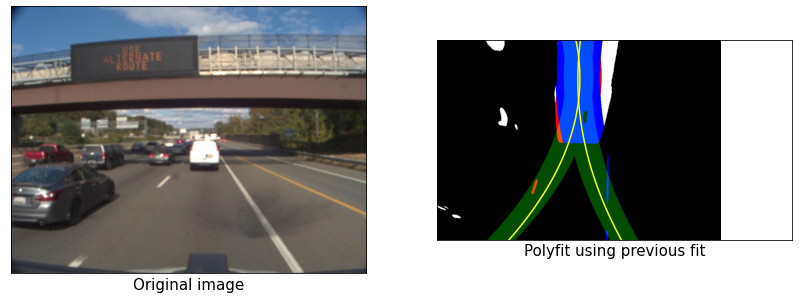

In [76]:
# Visualize the polyfit_prev_fit over the an example image.

margin = 50
left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window(img)
left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = polyfit_prev_fit(img, left_fit, right_fit)
ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
left_fitx2 = left_fit2[0]*ploty**2 + left_fit2[1]*ploty + left_fit2[2]
right_fitx2 = right_fit2[0]*ploty**2 + right_fit2[1]*ploty + right_fit2[2]
out_img = np.uint8(np.dstack((img, img, img))*255)
window_img = np.zeros_like(out_img)
nonzero = img.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 0, 255]
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.imshow(original)
plt.xlabel('Original image', fontsize=15)
plt.xticks([])
plt.yticks([])
plt.subplot(1, 2, 2)
plt.imshow(result)
plt.xlabel('Polyfit using previous fit', fontsize=15)
plt.plot(left_fitx2, ploty, color='yellow')
plt.plot(right_fitx2, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.xticks([])
plt.yticks([])
plt.show()

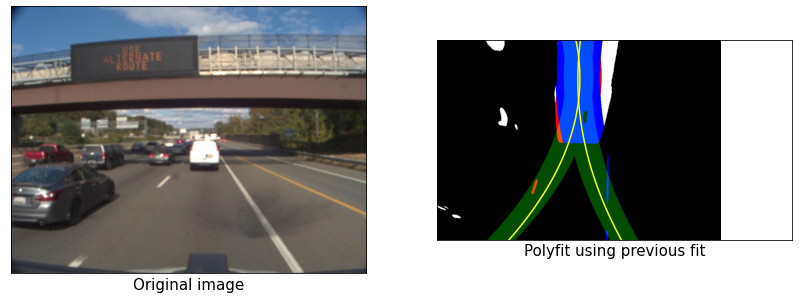

In [77]:
# visualizing polyfit_prev_fit over the test images.

for original, processed in zip(test_images_imgs, test_images_processed):
    img = processed
    margin = 50
    left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window(img)
    left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = polyfit_prev_fit(img, left_fit, right_fit)
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    left_fitx2 = left_fit2[0]*ploty**2 + left_fit2[1]*ploty + left_fit2[2]
    right_fitx2 = right_fit2[0]*ploty**2 + right_fit2[1]*ploty + right_fit2[2]
    out_img = np.uint8(np.dstack((img, img, img))*255)
    window_img = np.zeros_like(out_img)
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 0, 255]
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.xlabel('Original image', fontsize=15)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 2, 2)
    plt.imshow(result)
    plt.xlabel('Polyfit using previous fit', fontsize=15)
    plt.plot(left_fitx2, ploty, color='yellow')
    plt.plot(right_fitx2, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.xticks([])
    plt.yticks([])
    plt.show()

---
## Step 7: Determine the Curvature of the Lane and Vehicle Position

I've depended on this [tutorial](https://www.intmath.com/applications-differentiation/8-radius-curvature.php) to calculate the lane curvature. The curvature was calculated ussing this line of code:

`curve_radius = ((1 + (2*fit[0]*y_0*y_meters_per_pixel + fit[1])**2)**1.5) / np.absolute(2*fit[0])`

In this example, fit[0] is the first coefficient (the y-squared coefficient) of the second order polynomial fit, and fit[1] is the second coefficient. y_0 is the y position within the image upon which the curvature calculation is based. y_meters_per_pixel is the factor used for converting from pixels to meters. This conversion was also used to generate a new fit with coefficients in terms of meters.

The position of the vehicle with respect to the center of the lane is calculated with the following lines of code:

`lane_center_position = (r_fit_x_int + l_fit_x_int) /2
center_dist = (car_position - lane_center_position) * x_meters_per_pix`

r_fit_x_int and l_fit_x_int are the x-intercepts of the right and left fits, respectively. This requires evaluating the fit at the maximum y value because the minimum y value is actually at the top. The car position is the difference between these intercept points and the image midpoint (assuming that the camera is mounted at the center of the vehicle).

In [78]:
def curv_pos(img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    """
    Calculating the lane curvature and the vehicle position on the lane.
        Parameters:
            img: Input image.
            l_fit, r_fit, l_lane_inds, r_lane_inds: Detected lane lines.
    """
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3.048/100 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    xm_per_pix = 3.7/378 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    h = img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        car_position = img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist

Radius of curvature for example: 71.76802488135658 m, 106.5103798259884 m
Distance from lane center for example: 0.6697421106601636 m


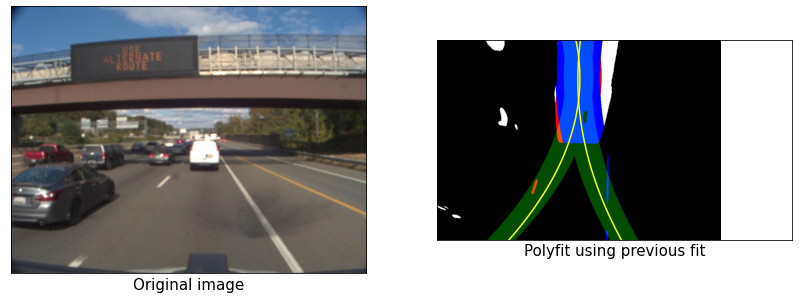

In [80]:
# Visualize the curv_pos over the an example image.

rad_l, rad_r, d_center = curv_pos(test_images_processed[0], left_fit, right_fit, left_lane_inds2, right_lane_inds2)
print('Radius of curvature for example:', rad_l, 'm,', rad_r, 'm')
print('Distance from lane center for example:', d_center, 'm')
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.imshow(original)
plt.xlabel('Original image', fontsize=15)
plt.xticks([])
plt.yticks([])
plt.subplot(1, 2, 2)
plt.imshow(result)
plt.xlabel('Polyfit using previous fit', fontsize=15)
plt.plot(left_fitx2, ploty, color='yellow')
plt.plot(right_fitx2, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.xticks([])
plt.yticks([])
plt.show()

Radius of curvature for example: 68.68785813588299 m, 102.20512391081283 m
Distance from lane center for example: 0.6697421106601636 m


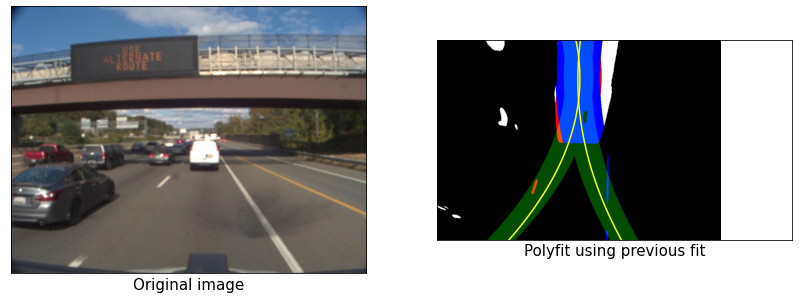

In [81]:
# Visualize the curv_pos over the test images.

for original, processed in zip(test_images_imgs, test_images_processed):
    left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window(processed)
    rad_l, rad_r, d_center = curv_pos(processed, left_fit, right_fit, left_lane_inds, right_lane_inds)
    print('Radius of curvature for example:', rad_l, 'm,', rad_r, 'm')
    print('Distance from lane center for example:', d_center, 'm')
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.xlabel('Original image', fontsize=15)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 2, 2)
    plt.imshow(result)
    plt.xlabel('Polyfit using previous fit', fontsize=15)
    plt.plot(left_fitx2, ploty, color='yellow')
    plt.plot(right_fitx2, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.xticks([])
    plt.yticks([])
    plt.show()


---
## Step 8: Visual display of the Lane Boundaries and Numerical Estimation of Lane Curvature and Vehicle Position

In [82]:
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    """
    Draw the detected lane over the input image.
        Parameters:
            original_img: Input frame.
            binary_img: Preprocessed image.
            l_fit, r_fit: Detected lanes.
            Minv: Calibration matrix.
    """
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result

In [83]:
def write_data(original_img, curv_rad, center_dist):
    """
    Write the lane curvature and vehicle position over the input image.
        Parameters:
            original_img: Input frame.
            curv_rad: Lane curvature.
            center_dist: Vehicle position.
    """
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (255,255,255), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (255,255,255), 2, cv2.LINE_AA)
    return new_img

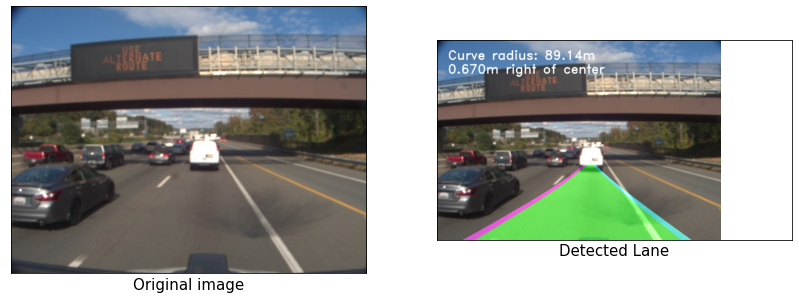

In [84]:
for original, processed in zip(test_images_imgs, test_images_processed):
    left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window(processed)
    left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = polyfit_prev_fit(processed, left_fit, right_fit)
    rad_l, rad_r, d_center = curv_pos(processed, left_fit, right_fit, left_lane_inds2, right_lane_inds2)
    result = draw_lane(original, processed, left_fit, right_fit, Minv)
    result = write_data(result, (rad_l+rad_r)/2, d_center)
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.xlabel('Original image', fontsize=15)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 2, 2)
    plt.imshow(result)
    plt.xlabel('Detected Lane', fontsize=15)
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.xticks([])
    plt.yticks([])
    plt.show()

---
## Step 9: Process Project Videos

In [85]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
    def add_fit(self, fit, inds):
        if fit is not None:
            self.detected = True
            self.px_count = np.count_nonzero(inds)
            self.current_fit.append(fit)
            if len(self.current_fit) > 5:
                self.current_fit = self.current_fit[len(self.current_fit)-5:]
            self.best_fit = np.average(self.current_fit, axis=0)
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                self.best_fit = np.average(self.current_fit, axis=0)

In [86]:
def frame_processor(img):
    """
    Process the input frame and return the frame with detected lane and curvature and vehicle position information.
        Parameters:
            img: Input frame.
    """
    new_img = undistort(np.copy(img), mtx, dist)
    img_bin, Minv = image_process(img)
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds, _ = sliding_window(img_bin)
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = polyfit_prev_fit(img_bin, l_line.best_fit, r_line.best_fit)
        
    l_line.add_fit(l_fit, l_lane_inds)
    r_line.add_fit(r_fit, r_lane_inds)
    img_out1 = draw_lane(new_img, img_bin, l_fit, r_fit, Minv)
    rad_l, rad_r, d_center = curv_pos(img_bin, l_fit, r_fit, l_lane_inds, r_lane_inds)
    img_out = write_data(img_out1, (rad_l+rad_r)/2, d_center)
    return img_out

**Processing the project video:**

In [58]:
l_line = Line()
r_line = Line()
project_video_output = 'project_video_output.mp4'
project_video_input = VideoFileClip('project_video.mp4')
processed_video = project_video_input.fl_image(frame_processor)
%time processed_video.write_videofile(project_video_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_output))

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:07<00:00,  5.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 4min 8s


**Processing the challenge video:**

In [59]:
l_line = Line()
r_line = Line()
challenge_video_output = 'challenge_video_output.mp4'
challenge_video_input = VideoFileClip('challenge_video.mp4')
processed_video = challenge_video_input.fl_image(frame_processor)
%time processed_video.write_videofile(challenge_video_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_video_output))

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 485/485 [01:31<00:00,  5.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

Wall time: 1min 33s


**Processing the harder challenge video:**

In [60]:
l_line = Line()
r_line = Line()
harder_challenge_video_output = 'harder_challenge_video_output.mp4'
harder_challenge_video_input = VideoFileClip('harder_challenge_video.mp4')
processed_video = harder_challenge_video_input.fl_image(frame_processor)
%time processed_video.write_videofile(harder_challenge_video_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(harder_challenge_video_output))

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1199/1200 [04:28<00:00,  4.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

Wall time: 4min 30s


**Processing the McLean 5-minute video:**

In [87]:
l_line = Line()
r_line = Line()
harder_challenge_video_output = 'mclean_output.mp4'
harder_challenge_video_input = VideoFileClip('2021-10-22-13-40-13_pacifica_mclean_loop_front_center_processed_5min.mp4')
processed_video = harder_challenge_video_input.fl_image(frame_processor)
%time processed_video.write_videofile(harder_challenge_video_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(harder_challenge_video_output))

Moviepy - Building video mclean_output.mp4.
Moviepy - Writing video mclean_output.mp4



Moviepy - Done !
Moviepy - video ready mclean_output.mp4
Wall time: 34min 2s


---
## Conclusion

The problems I encountered were almost exclusively due to lighting conditions, shadows, discoloration, etc. It wasn't difficult to detect the lane on the project video, even on the lighter-gray bridge sections that comprised the most difficult sections of the video.

On the other hand, the model didn't perform well on the challenge video and the harder challenge. The lane lines don't necessarily occupy the same pixel value (speaking of the L channel of the HLS color space) range on this video that they occupy on the first video, so the normalization/scaling technique helped here quite a bit, although it also tended to create problems (large noisy areas activated in the binary image) when the white lines didn't contrast with the rest of the image enough.
This would definitely be an issue in snow or in a situation where, for example, a bright white car were driving among dull white lane lines.
One way to solve this issue is to apply smoothing to the video output by averaging the last n found good fits. We can also invalidate fits if the left and right base points aren't a certain distance apart (within some tolerance) under the assumption that the lane width will remain relatively constant.

Other ways to improve the model include more dynamic thresholding, perhaps considering separate threshold parameters for different horizontal slices of the image, or dynamically selecting threshold parameters based on the resulting number of activated pixels, designating a confidence level for fits and rejecting new fits that deviate beyond a certain amount, or rejecting the right fit (for example) if the confidence in the left fit is high and right fit deviates too much (enforcing roughly parallel fits).